In [5]:
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv('../05_data_scraping/.env')
import os
# from sqlalchemy import create_engine
# import pymysql
# pymysql.install_as_MySQLdb()
# from dbio import er_to_db, db_connect
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import koreanize_matplotlib
import time
from konlpy.tag import Mecab
mecab = Mecab()
from nltk.probability import FreqDist
from wordcloud import WordCloud
import re

In [6]:
def string_delete(text) :
    return text.replace("<b>","").replace("</b>", "").replace("&quot;", "")

def parse_date(date_str):
    # 날짜 문자열을 datetime 객체로 변환
    return datetime.strptime(date_str, "%Y%m%d")

def make_df(df_name) :
    for i in df_name :
        for idx in range(0, len(df_name[i])) : 
            df_name[i][idx] = string_delete(df_name[i][idx])
    df_name['postdate'] = df_name['postdate'].apply(parse_date)
    return df_name

## 성수/10만개/정확도순/명사만

In [7]:
client_id = os.getenv('client_id') # 환경 변수에 접근
client_pw = os.getenv('client_pw') # 환경 변수에 접근

url = "https://openapi.naver.com/v1/search/blog.json"
final_data_sungsu = pd.DataFrame()
start = time.time() # 시작
for i in range(1, 1001) : 
    payload = {'query' : '성수', 'display' : 100, 'start' : i, 'sort' : 'sim'}
    headers = {'X-Naver-Client-Id' : client_id, 'X-Naver-Client-Secret' : client_pw}
    r = requests.get(url, params = payload, headers = headers)
    if r.status_code == 200 :
        data = r.json()
    else :
        print("Error Code:", r.status_code)
        
    
    df_sungsu_sim = pd.json_normalize(data['items'])
    entire_data_sungsu_sim = make_df(df_sungsu_sim)
    final_data_sungsu = pd.concat([final_data_sungsu, entire_data_sungsu_sim], ignore_index=True)
print(final_data_sungsu)
print(f"{time.time()-start:.4f} sec")

                                   title  \
0           성수동 카페거리 할아버지공장 성수역 대형 카페 추천   
1            [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나   
2        성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색   
3                        성수 핫플 맛집 자연도소금빵   
4              성수 서울숲 맛집 초밥은 기본 우니까지 맛있게   
...                                  ...   
99995    [성수카페추천 유아왓유잇] 라이스 베이스드 비건 성수팝업   
99996  무신사스토어 성수 @대림창고 매장, 2024 가을패션...    
99997   서울 성수나들이 ; 할아버지공장카페, 편안한 분위기가 좋아   
99998            성수 분위기 좋은 칵테일바 위스키바 조디악   
99999   무신사 스토어 성수 @대림창고 성수동 핫플 가을 패션 완성   

                                                   link  \
0      https://blog.naver.com/qkrgkdms1993/223637437253   
1          https://blog.naver.com/sssomina/223635003523   
2          https://blog.naver.com/songxxxx/223637484628   
3            https://blog.naver.com/roddl2/223634566375   
4          https://blog.naver.com/hohobaby/223631358628   
...                                                 ...   
99995   https://blog.naver.com/blk_lg_ryan/223616282386   

In [12]:
start = time.time() # 시작
final_data_sungsu = final_data_sungsu[['title', 'postdate']]
final_data_sungsu['title2'] = final_data_sungsu['title'].apply(lambda x : mecab.nouns(x))
print(final_data_sungsu.head())
print(f"{time.time()-start:.4f} sec")

                             title   postdate  \
0     성수동 카페거리 할아버지공장 성수역 대형 카페 추천 2024-10-28   
1      [성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나 2024-10-27   
2  성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색 2024-10-29   
3                  성수 핫플 맛집 자연도소금빵 2024-10-26   
4        성수 서울숲 맛집 초밥은 기본 우니까지 맛있게 2024-10-24   

                                         title2  
0       [성수동, 카페, 거리, 할아버지, 공장, 수역, 대형, 카페, 추천]  
1                 [성수, 속눈썹, 펌, 속눈썹, 펌, 곳, 스튜디오]  
2  [성수동, 미용실, 샵, 위드, 성수, 본점, 가을, 겨울맞이, 브라운, 염색]  
3                     [성수, 핫, 플, 맛집, 자연, 소금, 빵]  
4                     [성수, 서울숲, 맛집, 초밥, 기본, 우니]  
3.1864 sec


In [7]:
word_list_sungsu = []
for i in final_data_sungsu['title2'] : 
    for j in i :
        if j not in stopwords_sungsu :
            word_list_sungsu.append(j)
len(word_list_sungsu)

645323

<Axes: xlabel='Samples', ylabel='Counts'>

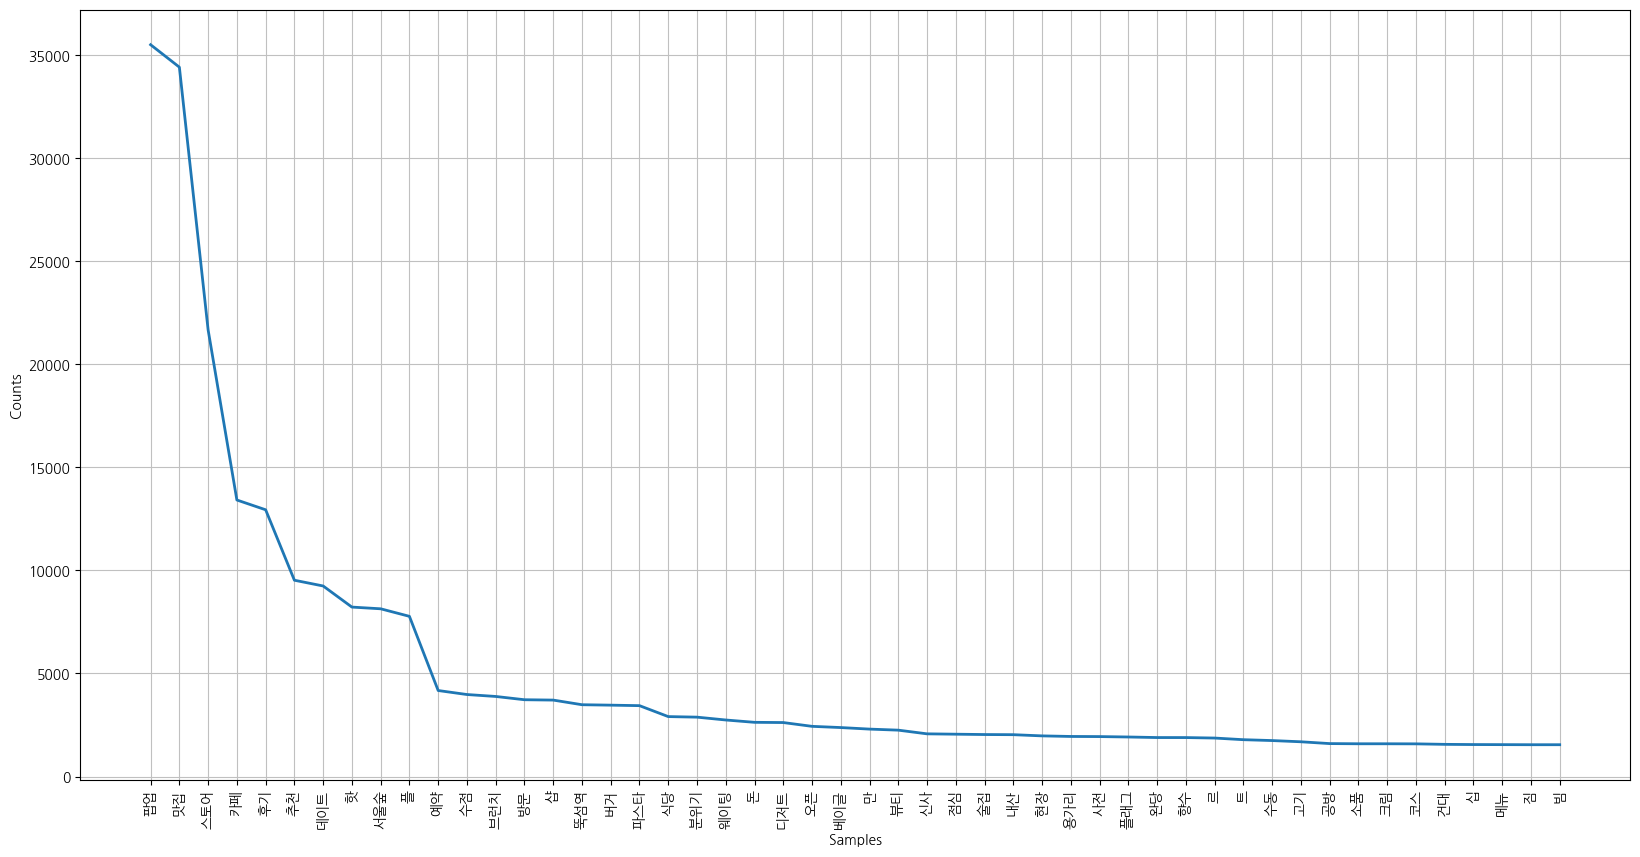

In [8]:
plt.figure(figsize = (20,10))
FreqDist(word_list_sungsu).plot(50)

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

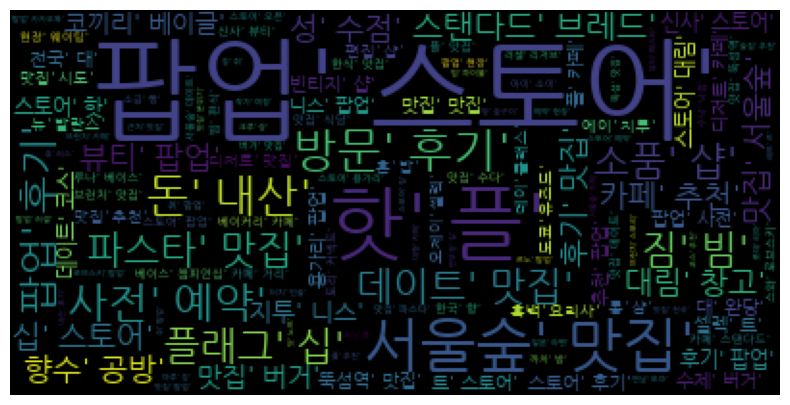

In [9]:
plt.figure(figsize = (10, 5))
wc_sungsu = WordCloud(font_path = '/user/share/fonts/truetype/nanum/NanumGothic.ttf').generate(str(word_list_sungsu))
plt.imshow(wc_sungsu)
plt.axis('off')

### 형태소_morphs

In [13]:
# final_data_sungsu_morphs = final_data_sungsu.copy()
final_data_sungsu_pos = final_data_sungsu.copy()

In [14]:
# final_data_sungsu_morphs = final_data_sungsu_morphs.drop('title2', axis = 1)
final_data_sungsu_pos = final_data_sungsu_pos.drop('title2', axis = 1)

In [15]:
# final_data_sungsu_morphs['title2'] = final_data_sungsu_morphs['title'].apply(lambda x: mecab.morphs(re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)))
final_data_sungsu_pos['title2'] = final_data_sungsu_pos['title'].apply(lambda x: mecab.pos(re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", x)))

#### stopwords

In [28]:
stopwords_sungsu = pd.read_csv('https://raw.githubusercontent.com/haram4th/ablearn/main/%ED%95%9C%EA%B5%AD%EC%96%B4%EB%B6%88%EC%9A%A9%EC%96%B4100.txt', header = None)
stopwords_sungsu

,0
0,이
1,있
2,하
3,것
4,들
...,...
104,원
105,잘
106,통하
107,소리


In [29]:
ex_stop_words = ['사람', '집', '시간', '여자', '생각']

In [30]:
for i in ex_stop_words : 
    stopwords_sungsu = stopwords_sungsu.drop(stopwords_sungsu[stopwords_sungsu[0] == i].index)

In [31]:
stopwords_sungsu.reset_index(drop=True, inplace=True)

In [32]:
stopwords_sungsu

,0
0,이
1,있
2,하
3,것
4,들
...,...
99,원
100,잘
101,통하
102,소리


### stopwords도 잘 안빠지고 pos랑 결과가 큰 차이가 없다면 굳이 morph로 하지 않기

### 형태소_pos

In [17]:
final_data_sungsu_pos

,title,postdate,title2
0,성수동 카페거리 할아버지공장 성수역 대형 카페 추천,2024-10-28,"[(성수동, NNP), (카페, NNG), (거리, NNG), (할아버지, NNG)..."
1,[성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나,2024-10-27,"[(성수, NNG), (속눈썹, NNG), (펌, NNG), (속눈썹, NNG), ..."
2,"성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색",2024-10-29,"[(성수동, NNP), (미용실, NNG), (샵, NNP), (위드, NNP), ..."
3,성수 핫플 맛집 자연도소금빵,2024-10-26,"[(성수, NNG), (핫, NNG), (플, NNG), (맛집, NNG), (자연..."
4,성수 서울숲 맛집 초밥은 기본 우니까지 맛있게,2024-10-24,"[(성수, NNP), (서울숲, NNP), (맛집, NNG), (초밥, NNG), ..."
...,...,...,...
99995,[성수카페추천 유아왓유잇] 라이스 베이스드 비건 성수팝업,2024-10-12,"[(성수, NNG), (카페, NNG), (추천, NNG), (유아, NNG), (..."
99996,"무신사스토어 성수 @대림창고 매장, 2024 가을패션...",2024-09-21,"[(무, XPN), (신사, NNG), (스토어, NNG), (성수, NNG), (..."
99997,"서울 성수나들이 ; 할아버지공장카페, 편안한 분위기가 좋아",2024-09-19,"[(서울, NNP), (성수, NNG), (나, NP), (들, XSN), (이, ..."
99998,성수 분위기 좋은 칵테일바 위스키바 조디악,2024-08-29,"[(성수, NNG), (분위기, NNG), (좋, VA), (은, ETM), (칵테..."


In [18]:
target = 'NNG', 'NNP', 'MAG', 'XR', 'NR', 'VV', 'VA', 'VCP', 'VCN', 'MM', 'IC', 'XPN', 'UNKNOWN'

In [19]:
def extract_words(words_list) : 
    return [word for word, pos in words_list if pos in target]

In [20]:
# 특정 형태소만 가져오기
final_data_sungsu_pos['filtered'] = final_data_sungsu_pos['title2'].apply(lambda x : extract_words(x))
final_data_sungsu_pos

,title,postdate,title2,filtered
0,성수동 카페거리 할아버지공장 성수역 대형 카페 추천,2024-10-28,"[(성수동, NNP), (카페, NNG), (거리, NNG), (할아버지, NNG)...","[성수동, 카페, 거리, 할아버지, 공장, 수역, 대형, 카페, 추천]"
1,[성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나,2024-10-27,"[(성수, NNG), (속눈썹, NNG), (펌, NNG), (속눈썹, NNG), ...","[성수, 속눈썹, 펌, 속눈썹, 펌, 잘, 하, 곳, 스튜디오, 트]"
2,"성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색",2024-10-29,"[(성수동, NNP), (미용실, NNG), (샵, NNP), (위드, NNP), ...","[성수동, 미용실, 샵, 위드, 성수, 본점, 가을, 겨울맞이, 브라운, 염색]"
3,성수 핫플 맛집 자연도소금빵,2024-10-26,"[(성수, NNG), (핫, NNG), (플, NNG), (맛집, NNG), (자연...","[성수, 핫, 플, 맛집, 자연, 소금, 빵]"
4,성수 서울숲 맛집 초밥은 기본 우니까지 맛있게,2024-10-24,"[(성수, NNP), (서울숲, NNP), (맛집, NNG), (초밥, NNG), ...","[성수, 서울숲, 맛집, 초밥, 기본, 우니, 맛있]"
...,...,...,...,...
99995,[성수카페추천 유아왓유잇] 라이스 베이스드 비건 성수팝업,2024-10-12,"[(성수, NNG), (카페, NNG), (추천, NNG), (유아, NNG), (...","[성수, 카페, 추천, 유아, 라이스, 베이스, 드, 비, 성수, 팝업]"
99996,"무신사스토어 성수 @대림창고 매장, 2024 가을패션...",2024-09-21,"[(무, XPN), (신사, NNG), (스토어, NNG), (성수, NNG), (...","[무, 신사, 스토어, 성수, 대림, 창고, 매장, 가을, 패션]"
99997,"서울 성수나들이 ; 할아버지공장카페, 편안한 분위기가 좋아",2024-09-19,"[(서울, NNP), (성수, NNG), (나, NP), (들, XSN), (이, ...","[서울, 성수, 할아버지, 공장, 카페, 편안, 분위기, 좋]"
99998,성수 분위기 좋은 칵테일바 위스키바 조디악,2024-08-29,"[(성수, NNG), (분위기, NNG), (좋, VA), (은, ETM), (칵테...","[성수, 분위기, 좋, 칵테일, 바, 위스, 키바, 조디악]"


In [21]:
sungsu_pos_word_list = []
for i in final_data_sungsu_pos['filtered'] : 
    for j in i :
        sungsu_pos_word_list.append(j)
len(sungsu_pos_word_list)

860452

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

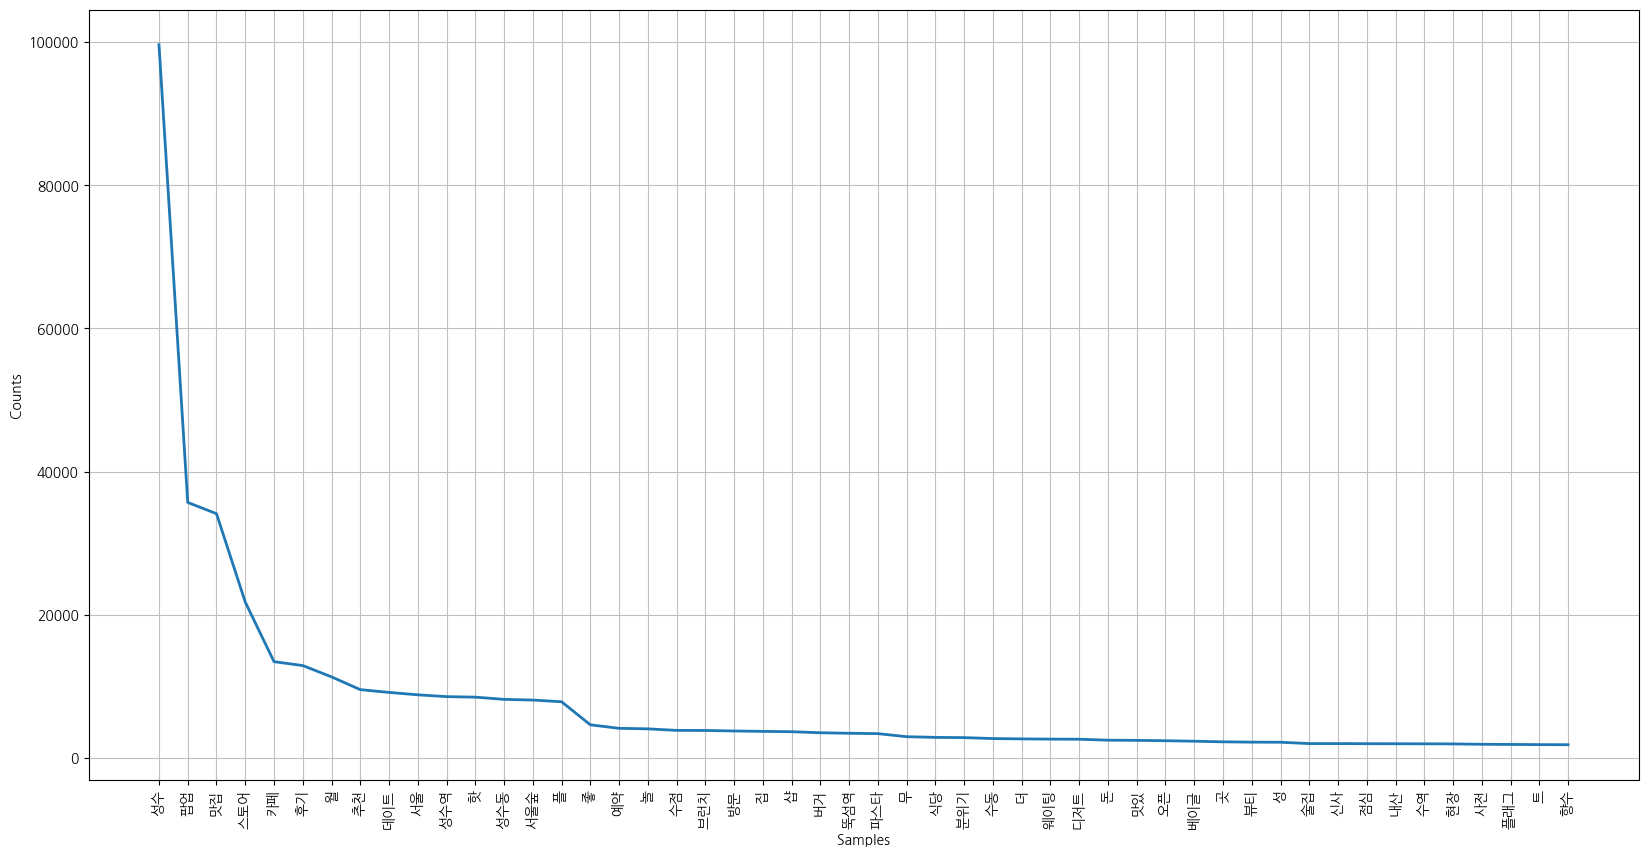

In [22]:
plt.figure(figsize = (20,10))
FreqDist(sungsu_pos_word_list).plot(50)

(-0.5, 399.5, 199.5, -0.5)

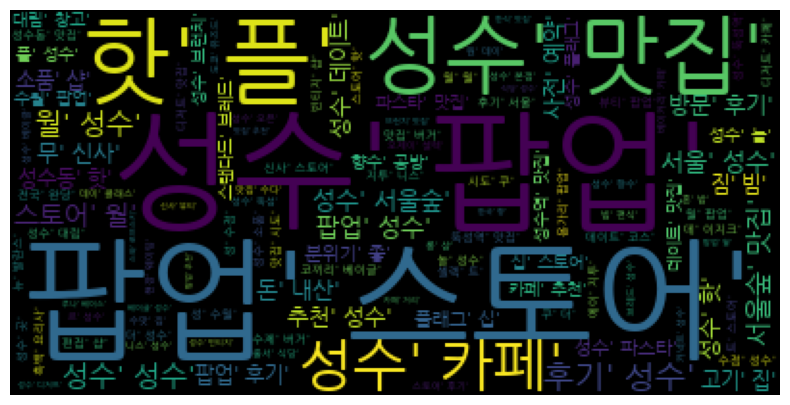

In [23]:
plt.figure(figsize = (10, 5))
wc_sungsu = WordCloud(font_path = '/user/share/fonts/truetype/nanum/NanumGothic.ttf').generate(str(sungsu_pos_word_list))
plt.imshow(wc_sungsu)
plt.axis('off')

#### gensim으로 word2vector 해보기

In [30]:
# !pip install gensim

In [31]:
# !pip install --upgrade numpy

In [24]:
final_data_sungsu_pos['filtered_list'] = final_data_sungsu_pos['filtered'].apply(lambda x : eval(x) if isinstance(x, str) else x)

In [25]:
from gensim.models import Word2Vec
model_sungsu_pos = Word2Vec(final_data_sungsu_pos['filtered_list'], vector_size=100, window=5, min_count=5, workers=8, sg=0)

/home/user/miniforge3/envs/project/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [63]:
model_sungsu_pos_result = model_sungsu_pos.wv.most_similar("성수", topn = 50)
print(model_sungsu_pos_result)

[('서울', 0.3252493441104889), ('플', 0.29801344871520996), ('아지트', 0.28377464413642883), ('퓌', 0.2657627761363983), ('일정', 0.25214919447898865), ('모음', 0.25156721472740173), ('추천', 0.24008134007453918), ('성', 0.22753289341926575), ('트', 0.22261402010917664), ('후기', 0.22127920389175415), ('전부', 0.21703141927719116), ('주말', 0.2151993364095688), ('음식', 0.21464285254478455), ('삼성전자', 0.2142622023820877), ('춥', 0.21169334650039673), ('성수동', 0.21135416626930237), ('무', 0.21126791834831238), ('뚝섬역', 0.2103927582502365), ('수동', 0.21027442812919617), ('데이트', 0.2012328803539276), ('장인', 0.2007361650466919), ('이', 0.2005481868982315), ('플라워', 0.19895438849925995), ('스톤', 0.1981329321861267), ('미디엄', 0.1964150369167328), ('브런치', 0.195330411195755), ('침대', 0.19241897761821747), ('다녀오', 0.19081297516822815), ('핫', 0.18888714909553528), ('즐기', 0.18822160363197327), ('성수역', 0.18756850063800812), ('카페', 0.18657484650611877), ('플레이스', 0.1852928251028061), ('급', 0.18435005843639374), ('더', 0.18346545100212

## 명사만 뺀 거 stopwords 넣어서 word2vec해보기

In [39]:
model_sungsu_noun = Word2Vec(final_data_sungsu['title2'], vector_size=100, window=5, min_count=5, workers=8, sg=0)

In [59]:
model_sungsu_noun_result = model_sungsu_noun.wv.most_similar("성수", topn = 50)
print(model_sungsu_noun_result)

[('후기', 0.26905182003974915), ('수동', 0.2534492313861847), ('서울', 0.251194566488266), ('핫', 0.24978363513946533), ('성수동', 0.2489972859621048), ('우체국', 0.23445218801498413), ('모음', 0.21929490566253662), ('민수', 0.21855156123638153), ('각', 0.21724772453308105), ('브롤', 0.212062269449234), ('드립', 0.20877331495285034), ('만', 0.20725253224372864), ('핸드', 0.20570668578147888), ('아지트', 0.20310193300247192), ('코스', 0.20178306102752686), ('덥', 0.19849234819412231), ('장인', 0.1981668472290039), ('팝업', 0.19242917001247406), ('용가리', 0.1898135393857956), ('삼성전자', 0.18942025303840637), ('플라워', 0.18781641125679016), ('주말', 0.18621289730072021), ('곳', 0.1858251988887787), ('구석구석', 0.18208831548690796), ('일정', 0.18206380307674408), ('시즌', 0.1817479282617569), ('세탁소', 0.18134962022304535), ('예약', 0.17683319747447968), ('아쥬', 0.17649534344673157), ('맥주', 0.17433971166610718), ('브런치', 0.17402927577495575), ('힙', 0.1727399379014969), ('조백', 0.17125873267650604), ('헤이', 0.1703881174325943), ('충족', 0.16889180243

In [47]:
final_data_sungsu.head()

,title,postdate,title2
0,성수동 카페거리 할아버지공장 성수역 대형 카페 추천,2024-10-28,"[성수동, 카페, 거리, 할아버지, 공장, 수역, 대형, 카페, 추천]"
1,[성수속눈썹펌] 속눈썹펌 잘하는곳 스튜디오 에트나,2024-10-27,"[성수, 속눈썹, 펌, 속눈썹, 펌, 곳, 스튜디오]"
2,"성수동 미용실 샵위드 성수본점, 가을겨울맞이 브라운 염색",2024-10-29,"[성수동, 미용실, 샵, 위드, 성수, 본점, 가을, 겨울맞이, 브라운, 염색]"
3,성수 핫플 맛집 자연도소금빵,2024-10-26,"[성수, 핫, 플, 맛집, 자연, 소금, 빵]"
4,성수 서울숲 맛집 초밥은 기본 우니까지 맛있게,2024-10-24,"[성수, 서울숲, 맛집, 초밥, 기본, 우니]"


In [50]:
final_data_sungsu['title3'] = final_data_sungsu['title'].apply(lambda x : re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", x))

In [55]:
final_data_sungsu['title3'] = final_data_sungsu['title3'].apply(lambda x : x.split(' '))

In [56]:
model_sungsu_split = Word2Vec(final_data_sungsu['title3'], vector_size=100, window=5, min_count=5, workers=8, sg=0)

In [60]:
model_sungsu_split_result = model_sungsu_split.wv.most_similar("성수동", topn = 50)
print(model_sungsu_split_result)

[('추천', 0.5017144083976746), ('도도한면', 0.4707017242908478), ('성수낙낙점', 0.44273093342781067), ('아구찜에', 0.431128591299057), ('곱창튀김', 0.4195011556148529), ('덥민수', 0.41679736971855164), ('가볼만한곳', 0.41621169447898865), ('플라워', 0.41618552803993225), ('파스타맛집', 0.40682750940322876), ('오키나와', 0.4043801724910736), ('브런치카페', 0.4028417468070984), ('소바식당', 0.40249767899513245), ('치맥', 0.4022502601146698), ('꽃집', 0.3997594118118286), ('부카케', 0.3991151452064514), ('맥주', 0.3960549235343933), ('사전예약링크', 0.395447313785553), ('짐빔편식당', 0.3798460066318512), ('구석구석', 0.37453803420066833), ('힙한', 0.37358006834983826), ('까치화방', 0.3719693422317505), ('퓨전음식', 0.37083134055137634), ('성수빵나오는', 0.36950182914733887), ('에르제', 0.36576616764068604), ('헤이숲', 0.3648507297039032), ('터치포굿', 0.36270299553871155), ('할리데이비슨', 0.36233675479888916), ('헤어', 0.3607630729675293), ('등극할', 0.35724374651908875), ('소금누룩', 0.3566402792930603), ('시간', 0.35597172379493713), ('곁들이기', 0.3554367423057556), ('핫플', 0.35507968068122864), ('새활용'